### Setup

In [264]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import copy
import datetime as dt
import math
from math import ceil
from matplotlib import colormaps
import PIL
import random
from IPython.display import display, clear_output
import kornia

try:
    # Mounting Colab Drive if possible
    from google.colab import drive
    drive.mount('/content/drive')

    # Cloning repo for colab
    if 'aml_itu' in os.getcwd():
        %cd aml_itu/
        !git pull https://github.com/RasKrebs/aml_itu
    else:
        !git clone https://github.com/RasKrebs/aml_itu
        %cd aml_itu/
    os.environ["COLAB"] = "True"

except:
    # Changing directory into aml_itu
    if os.getcwd().split('/')[-1] != 'aml_itu': os.chdir(os.path.abspath('.').split('aml_itu/')[0]+'aml_itu')
    !git pull origin main --ff-only
    os.environ["COLAB"] = "False"

# Utils Import
from utils.helpers import *
from utils.StatefarmPytorchDataset import StateFarmDataset


# Torch
import torch
from torch.autograd import Variable
from torch import nn
import torchvision
import torchvision.transforms as T
from torchvision.transforms import v2
from torch.utils.data import DataLoader
import torch.nn.functional as F
# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary


# Printing current working directory
print(os.getcwd())

# Setting up device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print (f"GPU is available")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print('MPS device found.')
else:
    print ("No GPU available, using CPU instead")
    
    
from utils.models.EfficientNet import EfficientNet
from utils.models.TinyVGG import TinyVGG
from utils.pipelines.image_transformation import image_transformer 

# Scikit learn accuracy score
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

From https://github.com/RasKrebs/aml_itu
 * branch            main       -> FETCH_HEAD
Already up to date.
/Users/rasmuskrebs/Documents/School/semester_3/advanced_ml/aml_itu
MPS device found.


In [7]:
# Load config
config = load_config(eval(os.environ["COLAB"]))

### Get data

In [181]:
def prepare_data(img_size='S', shuffle=False, return_just_test_data = False):
    # Target Transformations (Removing the c from the target)
    target_transform = T.Lambda(lambda y: torch.tensor(int(y.replace('c', ''))))
   
    # Predefined image sizes
    img_sizes = {
        'S': (48, 64),
        'M': (93, 124),
        'L':(168, 224),
        'L_SQUARED':(224, 224),
    }
    
    # Image augmentations - apply default if none is specified
    image_augmentations = v2.Compose([T.Resize(img_sizes[img_size], antialias=True),
                                      #T.RandomHorizontalFlip(p=.5),
                                      v2.ToDtype(torch.float32, scale=True)])
    
    # Creating the dataset
    test_data = StateFarmDataset(config, 
                            split='test', 
                            transform=image_augmentations if not return_just_test_data else None, 
                            target_transform=target_transform)
    
    if return_just_test_data:
        return test_data
    
    # Creating the dataloader
    test_loader = DataLoader(test_data, 
                            batch_size=32, 
                            shuffle=shuffle)
    
    return test_loader, test_data

#### Load Models

In [10]:
# Path and directory files
efficinetnet_path = os.path.join(config['outputs']['path'], 'EfficientNet_after_CV', 'EfficientNet_final.pt')

efficient = EfficientNet()

# Load parameters from last model
efficient.load_state_dict(torch.load(efficinetnet_path, map_location=torch.device('cpu')))
efficient.eval()

EfficientNet(
  (features): Sequential(
    (0): ConvBnAct(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): SiLU()
    )
    (1): MBConvN(
      (expand): Identity()
      (depthwise_conv): ConvBnAct(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): SiLU()
      )
      (se): SqueezeExcitation(
        (se): Sequential(
          (0): AdaptiveAvgPool2d(output_size=1)
          (1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (2): SiLU()
          (3): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (4): Sigmoid()
        )
      )
      (pointwise_conv): ConvBnAct(
        (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(

In [11]:
# Path and directory files
TinyVGG_path = os.path.join(config['outputs']['path'], 'TinyVGG_500k')
TinyVGG_file = 'TinyVGG_500k_final.pt'

# initalize model
tinyvgg = TinyVGG()

# Load parameters from last model
tinyvgg.load_state_dict(torch.load(os.path.join(TinyVGG_path, TinyVGG_file)))
tinyvgg.eval()

TinyVGG(
  (main): Sequential(
    (0): ConvBlock(
      (main): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): SELU(inplace=True)
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Dropout(p=0.25, inplace=False)
        (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (5): SELU(inplace=True)
        (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (8): Dropout(p=0.25, inplace=False)
      )
    )
    (1): ConvBlock(
      (main): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): SELU(inplace=True)
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Dropout(p=0.3, inplace=False)
        (4): Conv2d(64, 64, kerne

## Run Test

#### Vanilla Test

In [15]:
def test(model, 
         device,
         img_size='L_SQUARED'):
    """Test loop"""
    print('Starting test loop')
    # Prepare data
    test_loader, test_data = prepare_data(img_size=img_size)

    # Setup test accuracy
    test_acc = 0
    
    # Setup lists for storing images, classes and predictions
    images = []
    classes = []
    predictions = []
    predictions_argmax = []
    
    # Set model to eval
    model = model.eval()
    
    # Sent model to device
    model = model.to(device)
    
    print('Starting loop through test data...')
    # Disable gradient calculations
    with torch.no_grad():
        for i, data in enumerate(test_loader):   
            # Extract imgs and labels and sent to device
            imgs, labels = data
            images.append(imgs), classes.append(labels)
            
            imgs, labels  = imgs.to(device), labels.to(device)

            # Forward pass
            prediction = model(imgs)
            predictions.append(prediction)
            predictions_argmax.append(prediction.argmax(1))

            # Update test accuracy
            test_acc += (prediction.argmax(1) == labels).type(torch.float).mean().item()
    # Return test accuracy
    print(f'Test Done. Accuracy {test_acc / len(test_loader)}')
    return images, classes, predictions, predictions_argmax

In [124]:
test_prediction_efficient = test(efficient, device, img_size='L_SQUARED')

Starting test loop
Starting loop through test data...
Test Done. Accuracy 0.8056506849315068


In [17]:
test_prediction_tiny = test(tinyvgg, device, img_size='S')

Starting test loop
Loading test data
Starting loop through test data...
Test Done. Accuracy 0.805065639623224


### Simulated real life with weighted predictions

In [182]:
test_data = prepare_data(return_just_test_data=True)

# Sorting test data
test_data.metadata = test_data.metadata.sort_values(by=['subject', 'target','img'])
test_data.img_labels = test_data.metadata[['img','classname', 'img_path']]

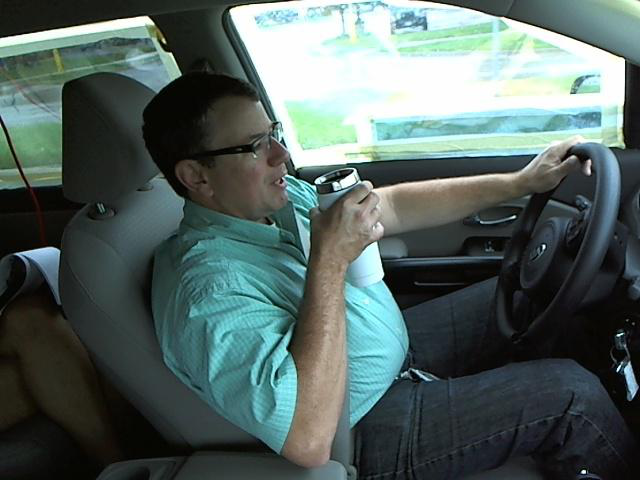

In [183]:
for img_path in test_data.img_labels.img_path.to_list()[:60]:
    img = PIL.Image.open(img_path)
    display(img)
    time.sleep(0.04)  # Delay in seconds (0.1s here)
    clear_output(wait=True)

In [187]:
def predict_image(image_tensor, model, device, img_size='L_SQUARED'):
    # Transform image
    frame = image_transformer(image_tensor, size=img_size)
    
    # Batch image
    frame = frame.unsqueeze(0)
    
    # Sent to device
    frame.to(device)
    
    # Predict
    model = model.eval()
    with torch.no_grad():
        # Get start time to compute inference time
        time_start = time.time()
        
        # Predict
        prediction = model(frame.to(device))
        
        # Get inference time
        time_final = time.time() - time_start
    
    return prediction, time_final
    

In [234]:
def sequential_image_predictor(model, test_data, image_size, weighted_prediction):
    # Setup lists for storing images, classes and predictions
    classes = []
    predictions_argmax = []
    weighted_predictions = []
    inference_times = []
    
    # Set model to eval
    model = model.eval()
    
    # Sent model to device
    model = model.to(device)
    
    # Disable gradient calculations
    with torch.no_grad():
        for i, data in enumerate(test_data):   
            # Extract imgs and labels and sent to device
            imgs, labels = data
            classes.append(labels.cpu().numpy())
            
            # Predict
            prediction, inference_time = predict_image(imgs, model, device, img_size=image_size)
            weighted_predictions.append(weighted_prediction(prediction))
            predictions_argmax.append(prediction.argmax(1).cpu().numpy())
            inference_times.append(inference_time)
            
            # Print progress
            if i % 100 == 0:
                print(f'Predicted {i} images')
            
    # Return test accuracy
    print(f'Test Done. Predicted {len(test_data)} images, with an average inference time of {np.mean(inference_times)}')
    return classes, predictions_argmax, weighted_predictions, inference_times

##### EfficientNet

In [235]:
# Generated weighted predictions object
weighted_predictor = weighted_prediction(config, n=10)

# Run predictions sequentially from sorted data
efficientnet_results = sequential_image_predictor(efficient, test_data, 'L_SQUARED', weighted_predictor)

Predicted 0 images
Predicted 100 images
Predicted 200 images
Predicted 300 images
Predicted 400 images
Predicted 500 images
Predicted 600 images
Predicted 700 images
Predicted 800 images
Predicted 900 images
Predicted 1000 images
Predicted 1100 images
Predicted 1200 images
Predicted 1300 images
Predicted 1400 images
Predicted 1500 images
Predicted 1600 images
Predicted 1700 images
Predicted 1800 images
Predicted 1900 images
Predicted 2000 images
Predicted 2100 images
Predicted 2200 images
Predicted 2300 images
Predicted 2400 images
Predicted 2500 images
Predicted 2600 images
Predicted 2700 images
Predicted 2800 images
Predicted 2900 images
Predicted 3000 images
Predicted 3100 images
Predicted 3200 images
Predicted 3300 images
Predicted 3400 images
Predicted 3500 images
Predicted 3600 images
Predicted 3700 images
Predicted 3800 images
Predicted 3900 images
Predicted 4000 images
Predicted 4100 images
Predicted 4200 images
Predicted 4300 images
Predicted 4400 images
Predicted 4500 images


In [300]:
# Extract results
classes = np.array(efficientnet_results[0])
efficient_argmax = np.array(efficientnet_results[1]).flatten()
efficient_weighted = np.array(efficientnet_results[2], dtype=np.float32)

# Mapped predictions
efficient_mapped = np.array([weighted_predictor.map_labels(i) for i in efficient_argmax])

# Classes mapped
classes_mapped = np.array([weighted_predictor.map_labels(i) for i in classes])


In [298]:
# Print accuracies
print(f'Accuracy of all predictions {np.mean(classes == efficient_argmax)}')
print(f'Accuracy of predictions excluding those outside scope of weighted predictor {np.mean(classes == efficient_argmax[9:])}')
print(f'Accuracy of weighted predictor {np.mean(classes[9:] == efficient_weighted[9:])}')

Accuracy of all predictions 0.8059957173447537
Accuracy of predictions excluding those outside scope of weighted predictor 0.0
Accuracy of weighted predictor 0.8120574983909032


/var/folders/v_/xl6xsh6x00990b93wzxm2j8c0000gn/T/ipykernel_94681/3443105216.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  print(f'Accuracy of predictions excluding those outside scope of weighted predictor {np.mean(classes == efficient_argmax[9:])}')


In [274]:
# Print F1, precision and recall scores
print(f'F1 score of all predictions {f1_score(classes, efficient_argmax, average="macro")}')
print(f'Precision score of all predictions {precision_score(classes, efficient_argmax, average="macro")}')
print(f'Recall score of all predictions {recall_score(classes, efficient_argmax, average="macro")}')

F1 score of all predictions 0.7872872137007733
Precision score of all predictions 0.813972594772391
Recall score of all predictions 0.798244560343244


In [307]:
config['dataset']['class_mapping'].values()

dict_values(['safe driving', 'texting - right', 'talking on the phone - right', 'texting - left', 'talking on the phone - left', 'operating the radio', 'drinking', 'reaching behind', 'hair and makeup', 'talking to passenger'])

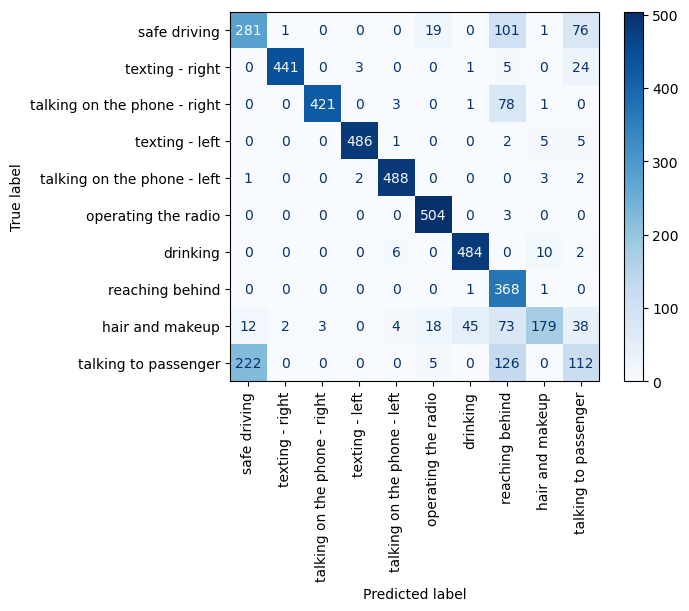

In [313]:
# Make confusion matrix
cm = confusion_matrix(classes, efficient_argmax)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=config['dataset']['class_mapping'].values())

disp.plot(cmap='Blues', values_format='d', xticks_rotation='vertical')

##### TinyVGG

In [314]:
# Generated weighted predictions object
weighted_predictor = weighted_prediction(config, n=10)

# Run predictions sequentially from sorted data
tiny_results = sequential_image_predictor(tinyvgg, test_data, 'S', weighted_predictor)

Predicted 0 images
Predicted 100 images
Predicted 200 images
Predicted 300 images
Predicted 400 images
Predicted 500 images
Predicted 600 images
Predicted 700 images
Predicted 800 images
Predicted 900 images
Predicted 1000 images
Predicted 1100 images
Predicted 1200 images
Predicted 1300 images
Predicted 1400 images
Predicted 1500 images
Predicted 1600 images
Predicted 1700 images
Predicted 1800 images
Predicted 1900 images
Predicted 2000 images
Predicted 2100 images
Predicted 2200 images
Predicted 2300 images
Predicted 2400 images
Predicted 2500 images
Predicted 2600 images
Predicted 2700 images
Predicted 2800 images
Predicted 2900 images
Predicted 3000 images
Predicted 3100 images
Predicted 3200 images
Predicted 3300 images
Predicted 3400 images
Predicted 3500 images
Predicted 3600 images
Predicted 3700 images
Predicted 3800 images
Predicted 3900 images
Predicted 4000 images
Predicted 4100 images
Predicted 4200 images
Predicted 4300 images
Predicted 4400 images
Predicted 4500 images


In [315]:
tinyvgg

TinyVGG(
  (main): Sequential(
    (0): ConvBlock(
      (main): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): SELU(inplace=True)
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Dropout(p=0.25, inplace=False)
        (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (5): SELU(inplace=True)
        (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (8): Dropout(p=0.25, inplace=False)
      )
    )
    (1): ConvBlock(
      (main): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): SELU(inplace=True)
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Dropout(p=0.3, inplace=False)
        (4): Conv2d(64, 64, kerne

In [ ]:
# Extract results
classes = np.array(efficientnet_results[0])
efficient_argmax = np.array(efficientnet_results[1]).flatten()
efficient_weighted = np.array(efficientnet_results[2], dtype=np.float32)

# Mapped predictions
efficient_mapped = np.array([weighted_predictor.map_labels(i) for i in efficient_argmax])

# Classes mapped
classes_mapped = np.array([weighted_predictor.map_labels(i) for i in classes])


# Gradcam

In [119]:
# Global variables to store gradients and activations
gradients = None
activations = None

def backward_hook(module, inputs, outputs):
    global gradients
    gradients = outputs[0]  # Get the actual gradient tensor

def forward_hook(module, inputs, outputs):
    global activations
    activations = outputs
    
def grad_cam_test(model, img, layer, original_label=None, predicted_label=None, device='cpu'):
    """Function to generate Grad-CAM for a single image and a specified layer"""
    model.eval()
    img = img.to(device)

    # Register hooks on the specified layer
    layer.register_forward_hook(forward_hook)
    layer.register_full_backward_hook(backward_hook)

    # Forward pass
    with torch.enable_grad():
        img_input = img.unsqueeze(0).requires_grad_()
        prediction = model(img_input)
        prediction[:, prediction.argmax(1)].sum().backward()

        # Compute the heatmap
        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
        for i in range(activations.size()[1]):
            activations[:, i, :, :] *= pooled_gradients[i]
        heatmap = torch.mean(activations, dim=1).squeeze()
        heatmap = F.relu(heatmap)
        heatmap /= torch.max(heatmap)

        # Plotting
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(T.functional.to_pil_image(img, mode='RGB'))
        title = 'Original Image'
        if original_label is not None:
            title += f'\nTrue Label: {original_label}'
        axs[0].set_title(title)
        axs[0].axis('off')

        # Plot heatmap with adjusted parameters or different colormap
        heatmap_detached = heatmap.cpu().detach().numpy()  # Detach and move to CPU
        axs[1].imshow(heatmap_detached, cmap='jet', interpolation='nearest')
        axs[1].set_title('Heatmap')
        axs[1].axis('off')

        # Plot Grad-CAM
        overlay = T.functional.to_pil_image(heatmap.detach(), mode='F').resize(img.shape[1:3], resample=PIL.Image.BICUBIC)
        cmap = colormaps['jet']
        overlay = (255 * cmap(np.asarray(overlay) ** 2)[:, :, :3]).astype(np.uint8)
        axs[2].imshow(T.functional.to_pil_image(img, mode='RGB'))
        axs[2].imshow(overlay, alpha=0.4, interpolation='nearest')
        title = 'Grad-CAM'
        if predicted_label is not None:
            title += f'\nPredicted Label: {predicted_label}'
        axs[2].set_title(title)
        axs[2].axis('off')

        plt.show()
        
def run_gradcam(model, test_dataloader, device, num_images=10):
    # set model to eval and device
    model = model.eval()
    model = model.to(device)
    
    # Define layer to use for Grad-CAM
    try:
        layer = getattr(model, 'features')[-1]
    except:
        layer = model.main[2].main[4:7]
    
    # Assuming test_dataloader is your DataLoader instance
    random_data = []
    for imgs, labels in test_dataloader:
        random_data.extend(zip(imgs, labels))
        if len(random_data) >= num_images:
            break
        
    # Now random_data contains at least num_images (image, label) pairs
    # We select num_images pairs randomly
    selected_data = random.sample(random_data, num_images)
    
    # Apply grad_cam_test on each of these images
    for img, original_label in selected_data:
        img, original_label = img.to(device), original_label.to(device)
        img_input = img.unsqueeze(0)
        
        with torch.no_grad():
            prediction = model(img_input.to(device))
        predicted_label = prediction.argmax(1).item()  # Assuming single output label
    
        # Convert labels to actual names if necessary, e.g., using a label map
        original_label_name = config['dataset']['class_mapping'][f'c{original_label}']  # Replace label_map with your label mapping
        predicted_label_name = config['dataset']['class_mapping'][f'c{predicted_label}'] # Replace label_map with your label mapping
    
        grad_cam_test(model, img, layer, original_label_name, predicted_label_name, device)
    

### Testing on random images in test loader

In [120]:
test_dataloader, test_data = prepare_data(img_size='S', shuffle=True)

In [121]:
tinyvgg.main[2].main[4:]

Sequential(
  (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): SELU(inplace=True)
  (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Dropout(p=0.3, inplace=False)
)

In [122]:
run_gradcam(tinyvgg, test_dataloader, device, num_images=5)

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [118]:
tinyvgg.main[2].main[4:7]

Sequential(
  (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): SELU(inplace=True)
  (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [73]:
getattr(efficient, 'features')[-1]

ConvBnAct(
  (conv): Conv2d(320, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (batch_norm): BatchNorm2d(1280, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): SiLU()
)

In [90]:
efficient.features

Sequential(
  (0): ConvBnAct(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): SiLU()
  )
  (1): MBConvN(
    (expand): Identity()
    (depthwise_conv): ConvBnAct(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): SiLU()
    )
    (se): SqueezeExcitation(
      (se): Sequential(
        (0): AdaptiveAvgPool2d(output_size=1)
        (1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
        (2): SiLU()
        (3): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        (4): Sigmoid()
      )
    )
    (pointwise_conv): ConvBnAct(
      (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm): BatchNorm2d(16, eps=1e-05, momentum